Import libraries

In [1]:
# Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.models import Sequential
import cv2 as cv
import os
from sklearn.model_selection import train_test_split

In [2]:
runtime_location = 'local' # 'local' or 'colab'
directory_header = 'drive/MyDrive/Hology/' if runtime_location == 'colab' else './'

if runtime_location == 'colab':
  from google.colab import drive
  drive.mount('/content/drive')

Load train csv data

In [3]:
# Load Train CSV

TRAIN_CSV_PATH = directory_header + 'dataset/train.csv'

df_train = pd.read_csv(TRAIN_CSV_PATH)

df_train.head()

,id,jenis,warna
0,1,1,1
1,2,0,2
2,3,1,3
3,4,1,1
4,5,0,4


Load train image data

In [4]:
# Load Train Images

X_raw_rgb = []
X_raw_gray = []
Y_shape = []
Y_color = []

TRAIN_IMG_PATH = directory_header + 'dataset/train/'

target_size = (224, 224)


for idx, file in enumerate(os.listdir(TRAIN_IMG_PATH)):

    file_path = os.path.join(TRAIN_IMG_PATH, file)

    # Load data in RGB format for color classification
    image_rgb = tf.keras.preprocessing.image.load_img(file_path, color_mode='rgb', target_size=target_size)
    image_rgb = tf.keras.preprocessing.image.img_to_array(image_rgb)
    # Load data in grayscale format for color classification
    image_gray = tf.keras.preprocessing.image.load_img(file_path, color_mode='grayscale', target_size=target_size)
    image_gray = tf.keras.preprocessing.image.img_to_array(image_gray)

    # Get file name
    file_id = os.path.splitext(file)[0]

    # Extract matching row, where id == name from train.csv
    matching_row = df_train[df_train['id'] == int(file_id)]

    if not matching_row.empty:
        X_raw_rgb.append(image_rgb)
        X_raw_gray.append(image_gray)
        Y_shape.append(matching_row['jenis'].values[0])
        Y_color.append(matching_row['warna'].values[0])
    else:
        print(f"No matching row found for file {file}")


# Convert to numpy array for easier manipulation
X_raw_gray = np.array(X_raw_gray)
X_raw_rgb = np.array(X_raw_rgb)
Y_shape = np.array(Y_shape)
Y_color = np.array(Y_color)

Preprocessing

In [5]:
# Check X, Y shape

print(f'X_rgb shape: {X_raw_rgb.shape}')
print(f'X_gray shape: {X_raw_gray.shape}')
print(f'Y_shape shape: {Y_shape.shape}')
print(f'Y_color shape: {Y_color.shape}\n')

# Check Y classes

shape_classes = np.unique(Y_shape)
color_classes = np.unique(Y_color)

print(f'Shape classes: {shape_classes}')
print(f'Color classes: {color_classes}')

X_rgb shape: (777, 224, 224, 3)
X_gray shape: (777, 224, 224, 1)
Y_shape shape: (777,)
Y_color shape: (777,)

Shape classes: [0 1]
Color classes: [0 1 2 3 4]


In [6]:
# Normalize X by pixel value

X_rgb_normalized = X_raw_rgb / 255
X_gray_normalized = X_raw_gray / 255

print(f'X rgb normalized minimum: {X_rgb_normalized.min()} | maximum: {X_rgb_normalized.max()}')
print(f'X gray normalized minimum: {X_gray_normalized.min()} | maximum: {X_gray_normalized.max()}')

X rgb normalized minimum: 0.0 | maximum: 1.0
X gray normalized minimum: 0.0 | maximum: 1.0


Label Classes

In [7]:
# Dictionary for label (based on kaggle's data)

index_to_shape_dict = {0 : 'Kaos', 1 : 'Hoodie'}
index_to_color_dict = {0: 'Merah', 1: 'Kuning', 2: 'Biru', 3: 'Hitam', 4: 'Putih'}

One-Hot Encoding

In [8]:
# Apply One hot encoding for Y_color (multi-class / more than 2)

def one_hot_encoding(Y: np.array, num_classes: int) -> np.array:

    encoded = tf.keras.utils.to_categorical(Y, num_classes= num_classes)

    return encoded

color_num_classes = color_classes.shape[0]

Y_color_encoded = one_hot_encoding(Y_color, color_num_classes)

print(Y_color_encoded.shape)

(777, 5)


Split data

In [9]:
# train test val split
# 80% train, 10% test, 10% val

X_rgb_normalized_hoodie = X_rgb_normalized[Y_shape == 1]
X_gray_normalized_hoodie = X_gray_normalized[Y_shape == 1]
Y_shape_hoodie = Y_shape[Y_shape == 1]
Y_color_encoded_hoodie = Y_color_encoded[Y_shape == 1]

X_rgb_normalized_kaos = X_rgb_normalized[Y_shape == 0][:len(X_rgb_normalized_hoodie)]
X_gray_normalized_kaos = X_gray_normalized[Y_shape == 0][:len(X_rgb_normalized_hoodie)]
Y_shape_kaos = Y_shape[Y_shape == 0][:len(X_rgb_normalized_hoodie)]
Y_color_encoded_kaos = Y_color_encoded[Y_shape == 0][:len(X_rgb_normalized_hoodie)]

# dataset split untuk yang rgb dulu (untuk model color classification)
X_rgb_kaos_train, X_rgb_kaos_temp, Y_color_encoded_kaos_train, Y_color_encoded_kaos_temp = train_test_split(X_rgb_normalized_kaos, Y_color_encoded_kaos, test_size=0.2, random_state=42)

X_rgb_kaos_test, X_rgb_kaos_val, Y_color_encoded_kaos_test, Y_color_encoded_kaos_val = train_test_split(X_rgb_kaos_temp, Y_color_encoded_kaos_temp, test_size=0.5, random_state=42)

X_rgb_hoodie_train, X_rgb_hoodie_temp, Y_color_encoded_hoodie_train, Y_color_encoded_hoodie_temp = train_test_split(X_rgb_normalized_hoodie, Y_color_encoded_hoodie, test_size=0.2, random_state=42)

X_rgb_hoodie_test, X_rgb_hoodie_val, Y_color_encoded_hoodie_test, Y_color_encoded_hoodie_val = train_test_split(X_rgb_hoodie_temp, Y_color_encoded_hoodie_temp, test_size=0.5, random_state=42)

X_rgb_train = np.concatenate([X_rgb_kaos_train, X_rgb_hoodie_train])
Y_color_encoded_train = np.concatenate([Y_color_encoded_kaos_train, Y_color_encoded_hoodie_train])

X_rgb_val = np.concatenate([X_rgb_kaos_val, X_rgb_hoodie_val])
Y_color_encoded_val = np.concatenate([Y_color_encoded_kaos_val, Y_color_encoded_hoodie_val])

X_rgb_test = np.concatenate([X_rgb_kaos_test, X_rgb_hoodie_test])
Y_color_encoded_test = np.concatenate([Y_color_encoded_kaos_test, Y_color_encoded_hoodie_test])


# dataset split untuk yang grayscale (untuk model shape classification)
X_gray_kaos_train, X_gray_kaos_temp, Y_shape_kaos_train, Y_shape_kaos_temp = train_test_split(X_gray_normalized_kaos, Y_shape_kaos, test_size=0.35, random_state=42)

X_gray_kaos_test, X_gray_kaos_val, Y_shape_kaos_test, Y_shape_kaos_val = train_test_split(X_gray_kaos_temp, Y_shape_kaos_temp, test_size=0.5, random_state=42)

X_gray_hoodie_train, X_gray_hoodie_temp, Y_shape_hoodie_train, Y_shape_hoodie_temp = train_test_split(X_gray_normalized_hoodie, Y_shape_hoodie, test_size=0.35, random_state=42)

X_gray_hoodie_test, X_gray_hoodie_val, Y_shape_hoodie_test, Y_shape_hoodie_val = train_test_split(X_gray_hoodie_temp, Y_shape_hoodie_temp, test_size=0.5, random_state=42)

X_gray_train = np.concatenate([X_gray_kaos_train, X_gray_hoodie_train])
Y_shape_train = np.concatenate([Y_shape_kaos_train, Y_shape_hoodie_train])

X_gray_val = np.concatenate([X_gray_kaos_val, X_gray_hoodie_val])
Y_shape_val = np.concatenate([Y_shape_kaos_val, Y_shape_hoodie_val])

X_gray_test = np.concatenate([X_gray_kaos_test, X_gray_hoodie_test])
Y_shape_test = np.concatenate([Y_shape_kaos_test, Y_shape_hoodie_test])

# Check shape

print(f"X_rgb_train shape: {X_rgb_train.shape} | test: {X_rgb_test.shape} | val: {X_rgb_val.shape}")
print(f"Y_color_encoded_train shape: {Y_color_encoded_train.shape} | test: {Y_color_encoded_test.shape} | val: {Y_color_encoded_val.shape}")

print(f"X_gray_train shape: {X_gray_train.shape} | test: {X_gray_test.shape} | val: {X_gray_val.shape}")
print(f"Y_shape_train shape: {Y_shape_train.shape} | test: {Y_shape_test.shape} | val: {Y_shape_val.shape}")

X_rgb_train shape: (480, 224, 224, 3) | test: (60, 224, 224, 3) | val: (62, 224, 224, 3)
Y_color_encoded_train shape: (480, 5) | test: (60, 5) | val: (62, 5)
X_gray_train shape: (390, 224, 224, 1) | test: (106, 224, 224, 1) | val: (106, 224, 224, 1)
Y_shape_train shape: (390,) | test: (106,) | val: (106,)


Shuffle dataset

In [10]:
from sklearn.utils import shuffle

# Shuffle the training set
X_rgb_train, Y_color_encoded_train = shuffle(X_rgb_train, Y_color_encoded_train, random_state=0)
X_rgb_val, Y_color_encoded_val = shuffle(X_rgb_val, Y_color_encoded_val, random_state=0)
X_rgb_test, Y_color_encoded_test = shuffle(X_rgb_test, Y_color_encoded_test, random_state=0)

X_gray_train, Y_shape_train = shuffle(X_gray_train, Y_shape_train, random_state=0)
X_gray_val, Y_shape_val = shuffle(X_gray_val, Y_shape_val, random_state=0)
X_gray_test, Y_shape_test = shuffle(X_gray_test, Y_shape_test, random_state=0)

<h1>Shape classifier modelling</h1>

In [11]:
SHAPE_CLASSIFIER_INPUT_SHAPE = X_gray_train[0].shape
print(SHAPE_CLASSIFIER_INPUT_SHAPE)

(224, 224, 1)


In [12]:

import cv2 as cv
import numpy as np

def apply_sobel_filter(X_gray):
    """
    Applies the Sobel operator to a list of grayscale images.

    Args:
    X_gray (list or np.array): List or array of grayscale images.

    Returns:
    np.array: Array of images after applying Sobel operator.
    """
    sobel_results = []

    for img in X_gray:
        # Apply Sobel operator in the x direction
        sobel_x = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=7)
        # Apply Sobel operator in the y direction
        sobel_y = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=7)

        # Calculate the gradient magnitude
        sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

        # Normalize to uint8 (0-255)
        sobel_magnitude = np.uint8(np.clip(sobel_magnitude, 0, 255))

        # Append the combined results to the list
        sobel_results.append(sobel_magnitude)

    # Convert the list to a NumPy array
    return np.expand_dims(np.array(sobel_results), axis=-1)

# Example usage
X_gray_sobel_train = apply_sobel_filter(X_gray_train)
X_gray_sobel_val = apply_sobel_filter(X_gray_val)


Plot sample data

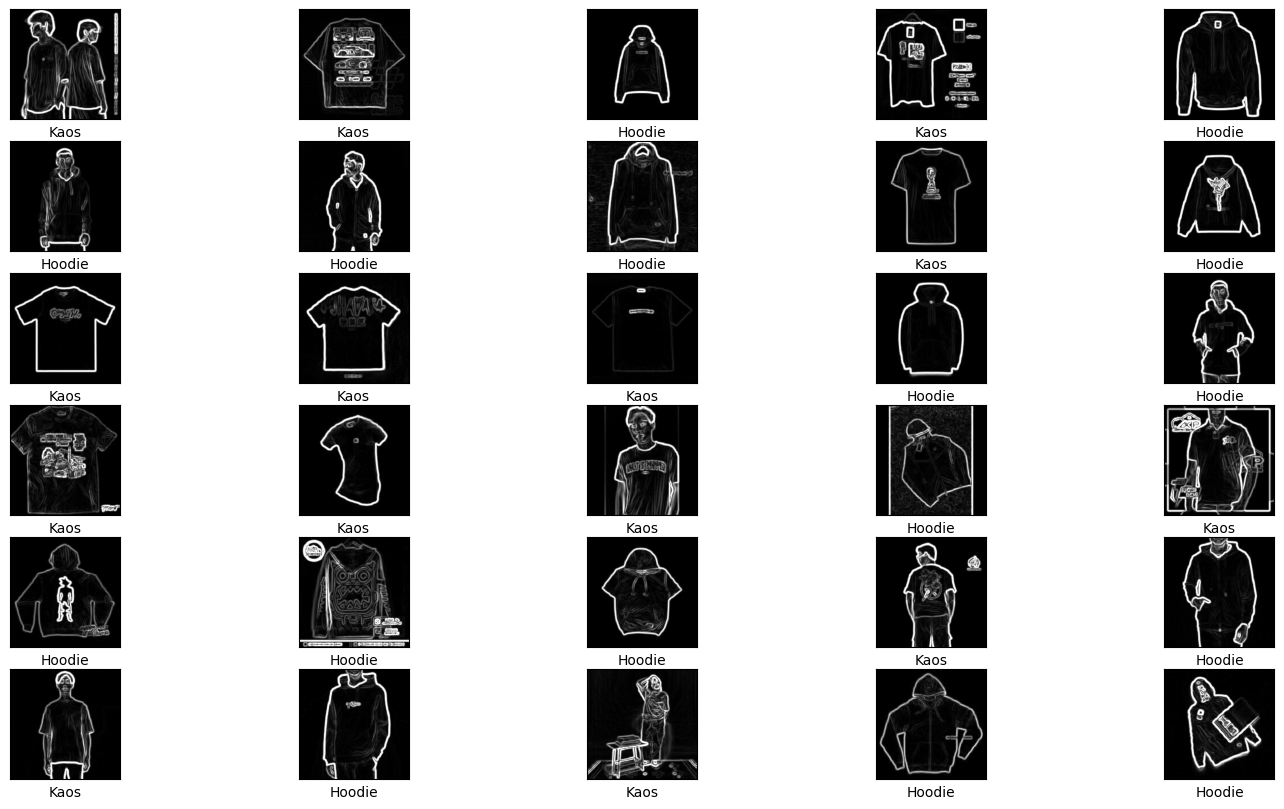

In [13]:
plt.figure(figsize=(18, 10))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_gray_sobel_train[i], cmap='gray')
    plt.xlabel(index_to_shape_dict[Y_shape_train[i]])
plt.show()

In [14]:
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=SHAPE_CLASSIFIER_INPUT_SHAPE),
#     Conv2D(32, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(2, 2),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(2, 2),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(2, 2),
#     Dropout(0.1),

#     Flatten(),

#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')
# ])

# (Strided CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=SHAPE_CLASSIFIER_INPUT_SHAPE),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid'),

])

lr = 0.00001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 dropout (Dropout)           (None, 28, 28, 128)       0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

def build_light_vgg(input_shape):
    model = Sequential([
        # First block
        tf.keras.layers.ZeroPadding2D(padding=(2, 2), input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.ZeroPadding2D(padding=(2, 2), input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Second block
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Third block
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Fourth block
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Fifth block
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(512, (3, 3), activation='relu'),
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Global Average Pooling
        tf.keras.layers.GlobalAveragePooling2D(),
        
        # Dense layers
        Dense(4096, activation='relu'),
        Dropout(0.5),
        
        Dense(1000, activation='relu'),
        Dropout(0.5),

        Dense(1, activation='sigmoid')  # Final classification
    ])
    
    return model


# Learning rate
lr = 0.00003

# Create the model
model = build_light_vgg(SHAPE_CLASSIFIER_INPUT_SHAPE)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_10 (ZeroPadd  (None, 228, 228, 1)      0         
 ing2D)                                                          
                                                                 
 conv2d_13 (Conv2D)          (None, 226, 226, 32)      320       
                                                                 
 zero_padding2d_11 (ZeroPadd  (None, 230, 230, 32)     0         
 ing2D)                                                          
                                                                 
 conv2d_14 (Conv2D)          (None, 228, 228, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 114, 114, 32)     0         
 2D)                                                             
                                                      

Train model

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define an image data generator with augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Fit the generator to your training data
data_gen.fit(X_gray_sobel_train) 
train_generator = data_gen.flow(X_gray_sobel_train, Y_shape_train, batch_size=32)


In [19]:
epochs = 50

history = model.fit(train_generator,
                    validation_data=(X_gray_sobel_val, Y_shape_val),
                    epochs=epochs, batch_size= 16)

Epoch 1/50


NotFoundError: Graph execution error:

Detected at node 'sequential_2/conv2d_16/Relu' defined at (most recent call last):
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 529, in dispatch_queue
      await self.process_one()
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 518, in process_one
      await dispatch(*args)
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 424, in dispatch_shell
      await result
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 766, in execute_request
      reply_content = await reply_content
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell
      result = self._run_cell(
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell
      result = runner(coro)
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ACER\AppData\Local\Temp\ipykernel_22776\3747299029.py", line 3, in <module>
      history = model.fit(train_generator,
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_2/conv2d_16/Relu'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 248954896 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16861824 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1043365888 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1043365888 bytes.
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 834813952 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 834813952 bytes.
  Profiling failure on CUDNN engine 6#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17188096 bytes.
  Profiling failure on CUDNN engine 6: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17188096 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 70254592 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 70254592 bytes.
  Profiling failure on CUDNN engine 7#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 548208640 bytes.
  Profiling failure on CUDNN engine 7: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 548208640 bytes.
	 [[{{node sequential_2/conv2d_16/Relu}}]] [Op:__inference_train_function_5076]

Analyze model result

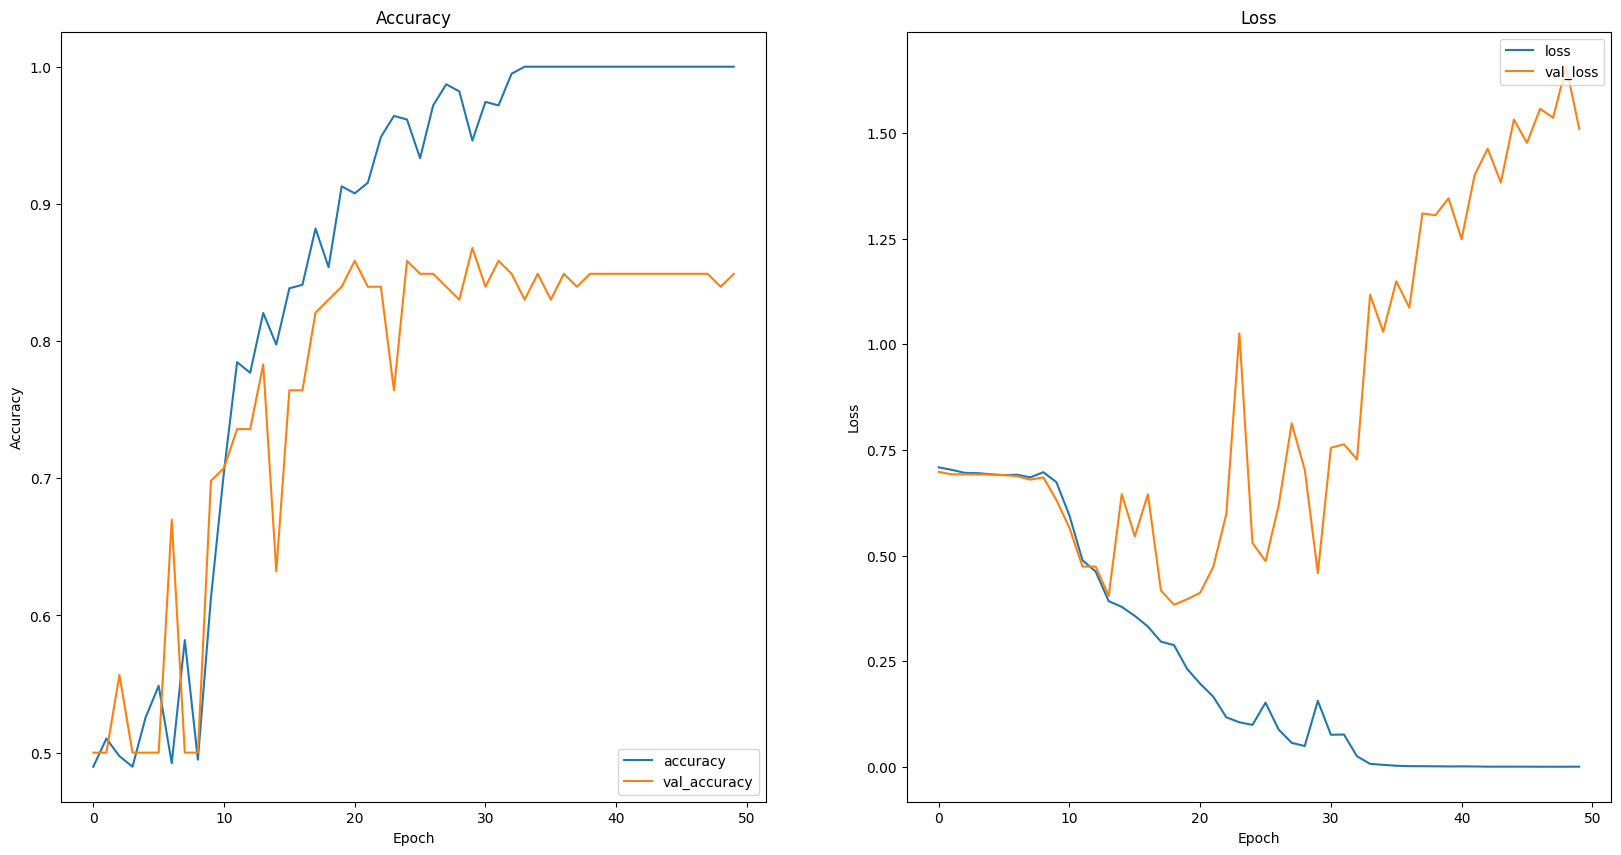

In [30]:
# Plot accuracy and loss

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Loss")

plt.show()

In [31]:
# Print test accuracy
test_loss, test_accuracy = model.evaluate(apply_sobel_filter(X_gray_test), Y_shape_test)

print(f"Test accuracy: {test_accuracy}")

4/4 [==============================] - 3s 71ms/step - loss: 0.9874 - accuracy: 0.8868
Test accuracy: 0.8867924809455872


<h1>Color Classifier Modelling</h1>

In [20]:
COLOR_CLASSIFIER_INPUT_SHAPE = X_rgb_train[0].shape
print(COLOR_CLASSIFIER_INPUT_SHAPE)

(224, 224, 3)


Plot sample data

TypeError: unhashable type: 'numpy.ndarray'

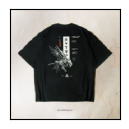

In [21]:
plt.figure(figsize=(30, 10))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_rgb_train[i])
    plt.xlabel(index_to_color_dict[Y_color_encoded_train[i]])
plt.show()

Load submission data

In [ ]:
# Load to-be-predicted Images
X_to_be_predicted = []

TEST_IMG_PATH = directory_header + "dataset/test/"

target_size = (224, 224)


for idx, file in enumerate(os.listdir(TEST_IMG_PATH)):

    file_path = os.path.join(TEST_IMG_PATH, file)

    # Load data in RGB format for color classification
    image = tf.keras.preprocessing.image.load_img(
        file_path, color_mode="grayscale", target_size=target_size
    )
    image = tf.keras.preprocessing.image.img_to_array(image)

    X_to_be_predicted.append(image)


# Convert to numpy array for easier manipulation
X_to_be_predicted = np.array(X_to_be_predicted)

print(X_to_be_predicted[0])

[[[67.]
  [68.]
  [69.]
  ...
  [68.]
  [68.]
  [68.]]

 [[66.]
  [67.]
  [68.]
  ...
  [68.]
  [68.]
  [68.]]

 [[67.]
  [67.]
  [69.]
  ...
  [68.]
  [68.]
  [68.]]

 ...

 [[44.]
  [43.]
  [43.]
  ...
  [36.]
  [36.]
  [37.]]

 [[43.]
  [43.]
  [42.]
  ...
  [35.]
  [35.]
  [36.]]

 [[43.]
  [43.]
  [42.]
  ...
  [34.]
  [34.]
  [35.]]]


In [ ]:
# Predict untrained data

X_to_be_predicted_normalized = X_to_be_predicted / 255

prediction_result = model.predict(X_to_be_predicted_normalized)
print(prediction_result.shape)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step
(334, 1)


In [ ]:
prediction_result_class = [0 if prediction < 0.5 else 1 for prediction in prediction_result]
print(prediction_result_class)

[1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 